In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torchvision.transforms as transforms
import torch
import matplotlib.patches as patches
from PIL import Image

(284, 177)
JPEG
RGB


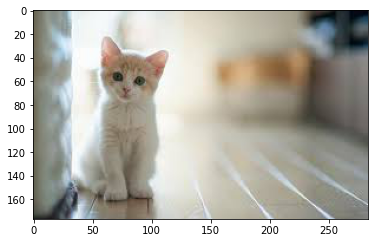

In [44]:
img_path = 'example.jpeg'
img = Image.open(img_path)
print(img.size)
print(img.format)
print(img.mode)
plt.imshow(img)

Reshaped image size: (144, 144)


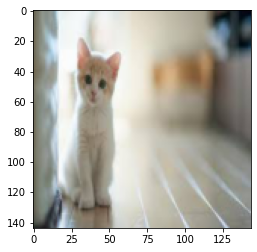

In [45]:
img = transforms.Resize((144,144))(img)

print("Reshaped image size: {}".format(img.size))
plt.imshow(img)

## Boxes for Ensemble

In [46]:
boxes_list = [
    [
        [15, 30, 52, 140],
        [34, 20, 78, 130],
    ],
    [
        [30, 45, 68, 140],
        [25, 5, 64, 110],
    ]
]
for model_boxes in boxes_list:
    for box in model_boxes:
        box[0] /= 144.
        box[1] /= 144.
        box[2] /= 144.
        box[3] /= 144.

scores_list = [[0.98, 0.78], [0.86, 0.82]]
labels_list = [[1, 1],[1, 1]]
weights=[1,1]

iou_thr = 0.0
skip_box_thr = 0.01

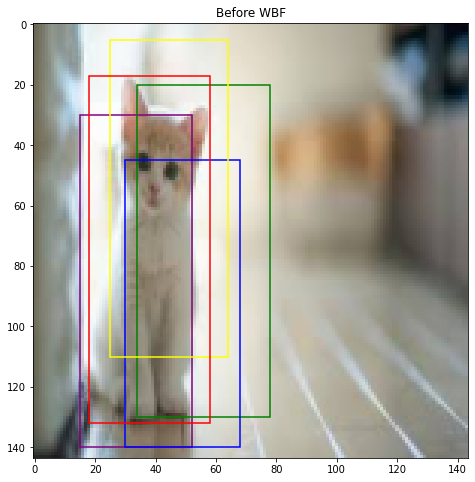

In [47]:
fig, ax = plt.subplots(figsize=(8,8))
gt_box = [18, 17, 58, 132]
box1 = [15, 30, 52, 140]
box2 = [34, 20, 78, 130]
box3 = [30, 45, 68, 140]
box4 = [25, 5, 64, 110]

ax.imshow(img)
ax.add_patch(patches.Rectangle((box1[0],box1[1]), box1[2]-box1[0],box1[3]-box1[1], edgecolor='purple', linewidth=1.5, fill=False))
ax.add_patch(patches.Rectangle((box2[0],box2[1]), box2[2]-box2[0],box2[3]-box2[1], edgecolor='green', linewidth=1.5, fill=False))
ax.add_patch(patches.Rectangle((box3[0],box3[1]), box3[2]-box3[0],box3[3]-box3[1], edgecolor='blue', linewidth=1.5, fill=False))
ax.add_patch(patches.Rectangle((box4[0],box4[1]), box4[2]-box4[0],box4[3]-box4[1], edgecolor='yellow', linewidth=1.5, fill=False))
ax.add_patch(patches.Rectangle((gt_box[0],gt_box[1]), gt_box[2]-gt_box[0],gt_box[3]-gt_box[1], edgecolor='red', linewidth=1.5, fill=False))

plt.title('Before WBF')
plt.show()

## WBF

In [48]:
def intersection_over_union(box1, box2):
    box1_xmin, box1_ymin, box1_xmax, box1_ymax = box1[0], box1[1], box1[2], box1[3]
    box2_xmin, box2_ymin, box2_xmax, box2_ymax = box2[0], box2[1], box2[2], box2[3]
    
    inter_xmin = max(box1_xmin, box2_xmin)
    inter_ymin = max(box1_ymin, box2_ymin)
    inter_xmax = min(box1_xmax, box2_xmax)
    inter_ymax = min(box1_ymax, box2_ymax)
    
    intersection = max(0,(inter_xmax - inter_xmin)) * max(0,(inter_ymax - inter_ymin))
    union = (
        (box1_xmax - box1_xmin) * (box1_ymax - box1_ymin)
        + (box2_xmax - box2_xmin) * (box2_ymax - box2_ymin)
        - intersection
    )
    
    return intersection / (union + 1e-6)

In [49]:
def wbf(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.5, skip_box_thr=0.05):
    N = len(boxes_list)
    # [1-1] Single list B
    B = [box for model_boxes in boxes_list for box in model_boxes]
    C = [score for model_scores in scores_list for score in model_scores]
    labels = [label for model_labels in labels_list for label in model_labels]

    # [1-1] Sort in decreasing order of the confidence scores C
    B = sorted(zip(labels,C,B), key=lambda x: x[1], reverse=True)
    for idx, b in enumerate(B):
        B[idx] = list(b)

    # [2] Declare empty lists: L for box clusters, F for fused boxes
    L = []
    F = []

    # [3] Iterate through B in a cycle and try to find a matching box in F. (IoU > iou_thr)
    for b_idx, b_box in enumerate(B):
        best_f_idx = -1
        best_iou = -1
        
        for f_idx, f_box in enumerate(F):
            iou = intersection_over_union(b_box[2], f_box[2])
            if iou > best_iou:
                best_iou = iou
                best_f_idx = f_idx

        # [5] Match Found: add b_box to L at position pos corresponding to the matching box in F
        if best_iou > iou_thr:
            L[best_f_idx].append(b_box)

            # [6] Perform WBF
            cum_C = 0.
            cum_xmin = 0.
            cum_ymin = 0.
            cum_xmax = 0.
            cum_ymax = 0.

            for l_box in L[best_f_idx]:
                l_label, l_conf, (xmin, ymin, xmax, ymax) = l_box
                cum_C += l_conf
                cum_xmin += l_conf * xmin
                cum_ymin += l_conf * ymin
                cum_xmax += l_conf * xmax
                cum_ymax += l_conf * ymax

            T = len(L[best_f_idx])
            new_C = cum_C / T
            new_xmin = cum_xmin / cum_C
            new_ymin = cum_ymin / cum_C
            new_xmax = cum_xmax / cum_C
            new_ymax = cum_ymax / cum_C
            F[best_f_idx] = [f_box[0], new_C, [new_xmin, new_ymin, new_xmax, new_ymax]]

        # [4] Match Not Found
        else:
            L.append([b_box])
            F.append(b_box)

    # [7] After all boxes in B are processed, Re-scale confidence scores of F
    for idx, f_box in enumerate(F):
        T = len(L[idx])
        F[idx][1] *= (min(T,N) / N)
        
    return F

# WBF
        
ensembled_boxes = wbf(boxes_list, scores_list, labels_list, iou_thr=0.3, skip_box_thr=0.01)
print(ensembled_boxes)

[[1, 0.8599999999999999, [0.1766795865633075, 0.1772448320413437, 0.44969315245478036, 0.9068152454780362]]]


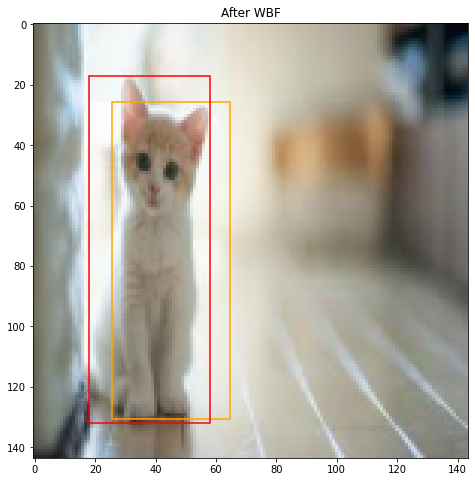

In [50]:
fig, ax = plt.subplots(figsize=(8,8))
gt_box = [18, 17, 58, 132]
box1 = [0.1766795865633075, 0.1772448320413437, 0.44969315245478036, 0.9068152454780362]

box1 = [144 * c for c in box1]

box3 = [30, 45, 68, 125]
box4 = [25, 28, 74, 132]

ax.imshow(img)
ax.add_patch(patches.Rectangle((box1[0],box1[1]), box1[2]-box1[0],box1[3]-box1[1], edgecolor='orange', linewidth=1.5, fill=False))
# ax.add_patch(patches.Rectangle((box2[0],box2[1]), box2[2]-box2[0],box2[3]-box2[1], edgecolor='green', linewidth=1.5, fill=False))
# ax.add_patch(patches.Rectangle((box3[0],box3[1]), box3[2]-box3[0],box3[3]-box3[1], edgecolor='blue', linewidth=1.5, fill=False))
# ax.add_patch(patches.Rectangle((box4[0],box4[1]), box4[2]-box4[0],box4[3]-box4[1], edgecolor='yellow', linewidth=1.5, fill=False))
ax.add_patch(patches.Rectangle((gt_box[0],gt_box[1]), gt_box[2]-gt_box[0],gt_box[3]-gt_box[1], edgecolor='red', linewidth=1.5, fill=False))

plt.title('After WBF')
plt.show()

In [51]:
from ensemble_boxes import *

boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, iou_thr=0.3, skip_box_thr=0.01)